In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"


Data loading using zipfile

In [2]:
import zipfile

In [3]:
zip_path = "/home/deepaksr/project/project_assignment1/seekthermal.zip"
folder_path = "/home/deepaksr/project/project_assignment1/data3"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(folder_path)
    
print(f"Data extracted to {folder_path}")

Data extracted to /home/deepaksr/project/project_assignment1/data4


Data Verification

In [4]:
import os

In [5]:
from PIL import Image # type: ignore

# Load the image
image = Image.open('/home/deepaksr/project/project_assignment1/data3/SeekThermal/Train/Car/003.jpg')

# Get the mode of the image, which indicates the number of channels
print("Image mode:", image.mode)

# To get the number of channels directly
num_channels = len(image.getbands())
print("Number of channels:", num_channels)


Image mode: RGB
Number of channels: 3


In [6]:
import cv2 # type: ignore

# Load the image
image = cv2.imread('/home/deepaksr/project/project_assignment1/data3/SeekThermal/Train/Car/006.jpg', -1)  # Load with all channels

# Get the shape of the image
print("Image shape:", image.shape)

# Number of channels is the last dimension
if len(image.shape) == 2:
    print("Number of channels: 1 (Grayscale)")
else:
    print(f"Number of channels: {image.shape[2]}")


Image shape: (400, 300, 3)
Number of channels: 3


In [7]:
train_path='/home/deepaksr/project/project_assignment1/data3/SeekThermal/Train'
#valid_path='/home/deepaksr/project/project_assignment1/data/valid'
test_path='/home/deepaksr/project/project_assignment1/data3/SeekThermal/Test'
def verify_data(folder):
  for classes in os.listdir(folder):
    class_path=os.path.join(folder,classes)
    if os.path.isdir(class_path):
      images = [i for i in os.listdir(class_path) if os.path.isfile(os.path.join(class_path,i))]
      counter = sum(1 for image in images if image.lower().endswith('.jpg'))
      print(f'class: {classes}')
      print(f'Images: {counter}\n')

print('Training Data:')
verify_data(train_path)
#print('Validation Data:')
#verify_data(valid_path)
print('Test Data:')
verify_data(test_path)

Training Data:
class: car
Images: 250

class: cat
Images: 272

class: man
Images: 289

Test Data:
class: car
Images: 147

class: cat
Images: 70

class: man
Images: 64



Data Augmentation using ImageDataGenerator & Data Generator using flow_from_directory 
(https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory)

In [8]:
import keras # type: ignore
import tensorflow as tf # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore

In [9]:
datagen= ImageDataGenerator(rotation_range=10,width_shift_range=0.05,height_shift_range=0.05,
                            horizontal_flip=True, rescale=1.0/255, validation_split=0.2)
train_generator = datagen.flow_from_directory(directory=train_path,
                                            target_size=(300,400),
                                            class_mode='categorical',
                                            batch_size=8,
                                            shuffle=True, subset='training')
val_generator = datagen.flow_from_directory(directory=train_path,
                                            target_size=(300,400),
                                            class_mode='categorical',
                                            batch_size=8,
                                            shuffle=True, subset='validation')
test_generator = datagen.flow_from_directory(directory=test_path,
                                            target_size=(300,400),
                                            class_mode='categorical',
                                            batch_size=8,
                                            shuffle=False)

print(train_generator.class_indices)
print(train_generator.samples)
print(val_generator.class_indices)
print(val_generator.samples)
print(test_generator.class_indices)
print(test_generator.samples)

Found 650 images belonging to 3 classes.
Found 161 images belonging to 3 classes.


Found 281 images belonging to 3 classes.
{'car': 0, 'cat': 1, 'man': 2}
650
{'car': 0, 'cat': 1, 'man': 2}
161
{'car': 0, 'cat': 1, 'man': 2}
281


Checking Shape of loaded data batches

In [6]:
x_train_batch, y_train_batch = next(train_generator)
x_valid_batch, y_valid_batch = next(val_generator)
x_test_batch, y_test_batch = next(test_generator)

print(f"Training batch shape: {x_train_batch.shape}, Labels shape: {y_train_batch.shape}")
print(f"Validation batch shape: {x_valid_batch.shape}, Labels shape: {y_valid_batch.shape}")
print(f"Test batch shape: {x_test_batch.shape}, Labels shape: {y_test_batch.shape}")

Training batch shape: (8, 300, 400, 3), Labels shape: (8, 3)
Validation batch shape: (8, 300, 400, 3), Labels shape: (8, 3)
Test batch shape: (8, 300, 400, 3), Labels shape: (8, 3)


Define the CNN using keras.models & keras.layers

In [7]:
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.utils import plot_model # type: ignore

In [8]:
def get_model():
  net = Sequential()
  net.add(Conv2D(32,(3,3), activation = 'relu', padding='same', input_shape=(300,400,3)))
  net.add(MaxPooling2D((2,2)))
  net.add(Conv2D(128,(3,3), activation='relu', padding='same'))
  net.add(MaxPooling2D((2,2)))
  net.add(Dropout(0.25))
  net.add(Flatten())
  #net.add(Dense(512, activation='relu'))
  net.add(Dense(16, activation='relu'))
  net.add(Dropout(0.25))
  net.add(Dense(3, activation='softmax'))
  net.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
  return net

Plotting & visualising the Network

In [9]:
model=get_model()
model.summary()

/home/deepaksr/miniconda3/envs/cnn/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-09-04 21:41:02.598133: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9798 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:86:00.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 300, 400, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 150, 200, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 150, 200, 128)  │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 75, 100, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 100, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 960000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │    15,360,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,397,955 (58.74 MB)

 Trainable params: 15,397,955 (58.74 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
plot_model(model, 'cnn.jpg', show_shapes=True,show_layer_names=True)

Training the Model: 25 Epochs 

In [10]:
history = model.fit(train_generator, validation_data=val_generator, epochs=15)

Epoch 1/15


/home/deepaksr/miniconda3/envs/cnn/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1725466281.952627 2971906 service.cc:146] XLA service 0x7f2c1c00bae0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725466281.952703 2971906 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-09-04 21:41:22.008738: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-04 21:41:22.209269: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907

  1/474 ━━━━━━━━━━━━━━━━━━━━ 59:07 7s/step - accuracy: 0.6250 - loss: 1.0284

I0000 00:00:1725466286.113236 2971906 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


474/474 ━━━━━━━━━━━━━━━━━━━━ 156s 313ms/step - accuracy: 0.6722 - loss: 1.3960 - val_accuracy: 0.6550 - val_loss: 0.8475
Epoch 2/15
474/474 ━━━━━━━━━━━━━━━━━━━━ 142s 295ms/step - accuracy: 0.8238 - loss: 0.4668 - val_accuracy: 0.6783 - val_loss: 1.0563
Epoch 3/15
474/474 ━━━━━━━━━━━━━━━━━━━━ 144s 299ms/step - accuracy: 0.8530 - loss: 0.3902 - val_accuracy: 0.6571 - val_loss: 1.1036
Epoch 4/15
474/474 ━━━━━━━━━━━━━━━━━━━━ 146s 304ms/step - accuracy: 0.8731 - loss: 0.3328 - val_accuracy: 0.6635 - val_loss: 0.9717
Epoch 5/15
474/474 ━━━━━━━━━━━━━━━━━━━━ 144s 300ms/step - accuracy: 0.8647 - loss: 0.3530 - val_accuracy: 0.6868 - val_loss: 0.9257
Epoch 6/15
474/474 ━━━━━━━━━━━━━━━━━━━━ 145s 303ms/step - accuracy: 0.8917 - loss: 0.2954 - val_accuracy: 0.6709 - val_loss: 0.9817
Epoch 7/15
474/474 ━━━━━━━━━━━━━━━━━━━━ 147s 305ms/step - accuracy: 0.8997 - loss: 0.2709 - val_accuracy: 0.6624 - val_loss: 1.1885
Epoch 8/15
474/474 ━━━━━━━━━━━━━━━━━━━━ 143s 299ms/step - accuracy: 0.8822 - loss: 0.27

In [11]:
history_dict = history.history

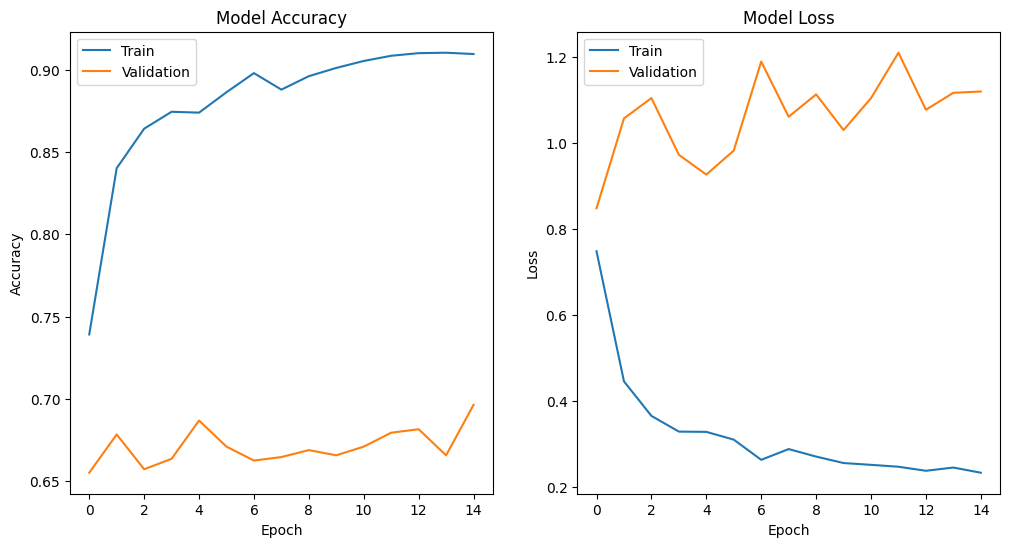

In [12]:
import matplotlib.pyplot as plt # type: ignore

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'])
plt.plot(history_dict['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.show()

Obtaining Predictions for testing & evaluation

In [13]:
import numpy as np # type: ignore
y_pred_prob=model.predict(test_generator)
y_pred=np.argmax(y_pred_prob, axis=1)
print(y_pred)
y_true=test_generator.classes
y_true

/home/deepaksr/miniconda3/envs/cnn/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


134/134 ━━━━━━━━━━━━━━━━━━━━ 39s 291ms/step
[0 0 2 ... 2 2 2]


array([0, 0, 0, ..., 2, 2, 2], dtype=int32)

In [14]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, classification_report # type: ignore
accuracy = accuracy_score(y_true,y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'Accuracy : {accuracy:.4f}')
print(f'Precision : {precision:.4f}')
print(f'Recall : {recall:.4f}')
print(f'F1 Score : {f1:.4f}')
print('Classification Report:\n', classification_report(y_true, y_pred,target_names=test_generator.class_indices.keys()))


Accuracy : 0.8839
Precision : 0.8986
Recall : 0.8839
F1 Score : 0.8811
Classification Report:
               precision    recall  f1-score   support

         car       0.93      0.97      0.95       356
         cat       0.97      0.71      0.82       356
         man       0.79      0.97      0.87       356

    accuracy                           0.88      1068
   macro avg       0.90      0.88      0.88      1068
weighted avg       0.90      0.88      0.88      1068



In [15]:
from sklearn.metrics import confusion_matrix # type: ignore
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[344   2  10]
 [ 21 253  82]
 [  4   5 347]]


CNN with different Arichitecture

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"


In [6]:
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.utils import plot_model # type: ignore

In [7]:
def get_model():
  net = Sequential()
  net.add(Conv2D(8,(3,3), activation = 'relu', padding='same', input_shape=(300,400,3)))
  net.add(MaxPooling2D((2,2)))
  net.add(Conv2D(16,(3,3), activation = 'relu', padding='same'))
  net.add(MaxPooling2D((2,2)))
  net.add(Dropout(0.25))
  net.add(Conv2D(32,(3,3), activation = 'relu', padding='same'))
  net.add(MaxPooling2D((2,2)))
  net.add(Conv2D(64,(3,3), activation = 'relu', padding='same'))
  net.add(MaxPooling2D((2,2)))
  net.add(Conv2D(128,(3,3), activation='relu', padding='same'))
  net.add(MaxPooling2D((2,2)))
  net.add(Dropout(0.25))
  net.add(Flatten())
  net.add(Dense(512, activation='relu'))
  net.add(Dense(16, activation='relu'))
  net.add(Dropout(0.25))
  net.add(Dense(3, activation='softmax'))
  net.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
  return net

Plotting & visualising the Network

In [8]:
model=get_model()
model.summary()

/home/deepaksr/miniconda3/envs/cnn/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-09-04 22:27:23.970936: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9798 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:86:00.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 300, 400, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 150, 200, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 150, 200, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 75, 100, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 100, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 75, 100, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 37, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 37, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 18, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 18, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 9, 12, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 9, 12, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 13824)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     7,078,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         8,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,185,043 (27.41 MB)

 Trainable params: 7,185,043 (27.41 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(train_generator, validation_data=val_generator, epochs=15)

Epoch 1/15


/home/deepaksr/miniconda3/envs/cnn/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1725469181.392563 2983564 service.cc:146] XLA service 0x7ff8f4011b50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725469181.392671 2983564 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-09-04 22:29:41.476782: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-04 22:29:41.835850: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907

  1/474 ━━━━━━━━━━━━━━━━━━━━ 1:13:25 9s/step - accuracy: 0.6250 - loss: 1.0602

I0000 00:00:1725469186.056944 2983564 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


474/474 ━━━━━━━━━━━━━━━━━━━━ 163s 325ms/step - accuracy: 0.6048 - loss: 0.8653 - val_accuracy: 0.6815 - val_loss: 0.8465
Epoch 2/15
474/474 ━━━━━━━━━━━━━━━━━━━━ 150s 312ms/step - accuracy: 0.8574 - loss: 0.3808 - val_accuracy: 0.7164 - val_loss: 0.7269
Epoch 3/15
474/474 ━━━━━━━━━━━━━━━━━━━━ 150s 312ms/step - accuracy: 0.8929 - loss: 0.3180 - val_accuracy: 0.6868 - val_loss: 1.1371
Epoch 4/15
474/474 ━━━━━━━━━━━━━━━━━━━━ 149s 309ms/step - accuracy: 0.9207 - loss: 0.2349 - val_accuracy: 0.7407 - val_loss: 0.7694
Epoch 5/15
474/474 ━━━━━━━━━━━━━━━━━━━━ 151s 315ms/step - accuracy: 0.9410 - loss: 0.1659 - val_accuracy: 0.7513 - val_loss: 1.2531
Epoch 6/15
474/474 ━━━━━━━━━━━━━━━━━━━━ 143s 298ms/step - accuracy: 0.9452 - loss: 0.1533 - val_accuracy: 0.7270 - val_loss: 1.0936
Epoch 7/15
474/474 ━━━━━━━━━━━━━━━━━━━━ 141s 294ms/step - accuracy: 0.9486 - loss: 0.1572 - val_accuracy: 0.7418 - val_loss: 1.0821
Epoch 8/15
474/474 ━━━━━━━━━━━━━━━━━━━━ 143s 298ms/step - accuracy: 0.9625 - loss: 0.11

In [10]:
history_dict = history.history

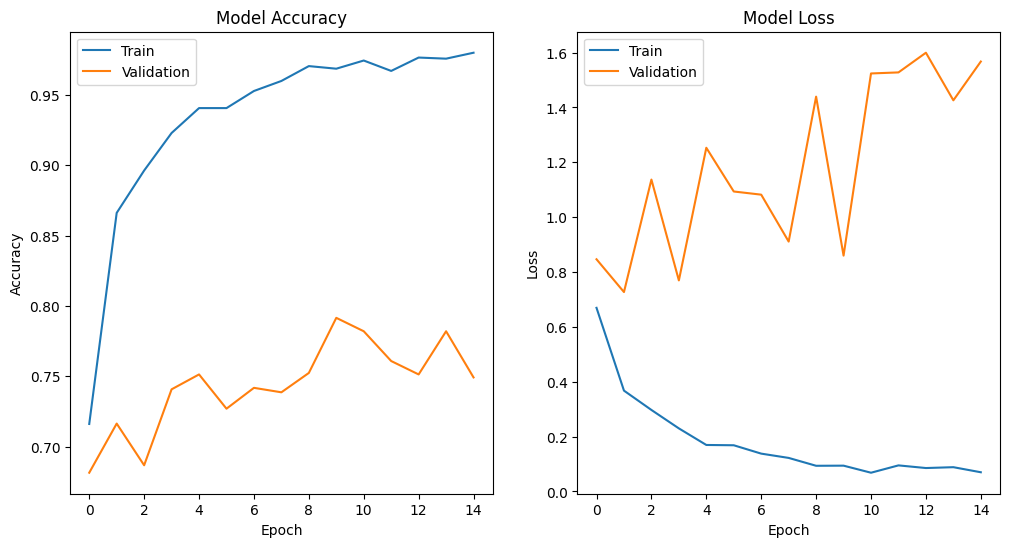

In [11]:
import matplotlib.pyplot as plt # type: ignore

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'])
plt.plot(history_dict['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.show()

Obtaining Predictions for testing & evaluation

In [12]:
import numpy as np # type: ignore
y_pred_prob=model.predict(test_generator)
y_pred=np.argmax(y_pred_prob, axis=1)
print(y_pred)
y_true=test_generator.classes
y_true

/home/deepaksr/miniconda3/envs/cnn/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


134/134 ━━━━━━━━━━━━━━━━━━━━ 35s 258ms/step
[0 0 0 ... 2 2 2]


array([0, 0, 0, ..., 2, 2, 2], dtype=int32)

In [13]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, classification_report # type: ignore
accuracy = accuracy_score(y_true,y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'Accuracy : {accuracy:.4f}')
print(f'Precision : {precision:.4f}')
print(f'Recall : {recall:.4f}')
print(f'F1 Score : {f1:.4f}')
print('Classification Report:\n', classification_report(y_true, y_pred,target_names=test_generator.class_indices.keys()))


Accuracy : 0.9354
Precision : 0.9456
Recall : 0.9354
F1 Score : 0.9355
Classification Report:
               precision    recall  f1-score   support

         car       1.00      0.98      0.99       356
         cat       1.00      0.83      0.91       356
         man       0.84      1.00      0.91       356

    accuracy                           0.94      1068
   macro avg       0.95      0.94      0.94      1068
weighted avg       0.95      0.94      0.94      1068



In [14]:
from sklearn.metrics import confusion_matrix # type: ignore
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[348   0   8]
 [  1 295  60]
 [  0   0 356]]
